In [255]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
random.seed(123)
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [317]:
def clean_reformat(dataset):
    dataset.loc[dataset.PossessionTeam == 'ARZ', 'PossessionTeam'] = 'ARI'
    dataset.loc[dataset.PossessionTeam == 'BLT', 'PossessionTeam'] = 'BAL'
    dataset.loc[dataset.PossessionTeam == 'CLV', 'PossessionTeam'] = 'CLE'
    dataset.loc[dataset.PossessionTeam == 'HST', 'PossessionTeam'] = 'HOU'
    dataset.loc[dataset.PossessionTeam == 'ARZ', 'FieldPosition'] = 'ARI'
    dataset.loc[dataset.PossessionTeam == 'BLT', 'FieldPosition'] = 'BAL'
    dataset.loc[dataset.PossessionTeam == 'CLV', 'FieldPosition'] = 'CLE'
    dataset.loc[dataset.PossessionTeam == 'HST', 'FieldPosition'] = 'HOU'
    dataset[['X', 'Y', 'S', 'A', 'Orientation']] = dataset[['X', 'Y', 'S', 'A', 'Orientation']].fillna(0)
    # dataset['GameSnap'] = dataset['GameId'].map(str) + dataset['TimeSnap'].map(str)
    # dataset['GameSnap'] = dataset['PlayId'].map(str)
    # dataset['TimeHandoff'] = pd.to_datetime(dataset['TimeHandoff'], format = "%Y-%m-%dT%H:%M:%S")
    # dataset['TimeSnap'] = pd.to_datetime(dataset['TimeSnap'], format = "%Y-%m-%dT%H:%M:%S")
    # # WindSpeed and WindDirection are switched for some rows in the dataset, the following script is used to switch them back to the sampe spot
    # mask = dataset['WindDirection'].map(lambda x: str(x).isnumeric()) & (dataset['WindSpeed'].map(lambda x: not str(x).isnumeric()))
    # wrong_ds = dataset[mask]
    # dataset.loc[mask, 'WindDirection'] = wrong_ds['WindSpeed']
    # dataset.loc[mask, 'WindSpeed'] = wrong_ds['WindDirection'].astype(int)
    # dataset['WindSpeed'] = dataset['WindSpeed'].apply(lambda x: numerize(x))
    # dataset['Stadium'] = dataset['Stadium'].str.replace('Stadium', '')
    # dataset['Stadium'] = dataset['Stadium'].str.strip()   # remove the leading spaces from the rows
    # dataset['WindSpeed'] = dataset['WindSpeed'].astype(str).str.replace('(mph|MPH|MPh|-.*|g.*)', '')
    # dataset['WindSpeed'] = dataset['WindSpeed'].astype(str).str.strip()
    # dataset.loc[dataset.WindSpeed == 'Calm', 'WindSpeed'] = '0'
    return dataset


In [318]:
# metadata
subset_rate, test_portion = 0.7, 0.2
dataset = pd.read_csv('../datasets/train.csv', low_memory=False)
dataset = clean_reformat(dataset)

In [ ]:
def train_test_split(dataset, subset_rate, test_portion):
    game_id = random.sample(list(dataset.GameId.unique()), int(subset_rate * len(dataset.GameId.unique())))
    test_id, train_id = game_id[:int(test_portion * len(game_id))], game_id[int(test_portion * len(game_id)):]
    train_plays = dataset.loc[dataset.GameId.isin(train_id), 'PlayId'].unique()
    test_plays = dataset.loc[dataset.GameId.isin(test_id), 'PlayId'].unique()
    # x_train, y_train = transform_train_test(train_plays)
    # x_test, y_test = transform_train_test(test_plays)
    return train_plays, test_plays


In [320]:
train_playid, test_playid = train_test_split(dataset, subset_rate = subset_rate, test_portion = test_portion)

In [321]:
def engineer_rusher_feature(dataset, play_id_list, is_train = True, is_submission = False, scaler = None):
    dataset['IsRusher'] = False
    dataset.loc[dataset.NflId == dataset.NflIdRusher, 'IsRusher'] = True
    # dataset['OffenseDefense'] = 'D'
    dataset['OffenseDefense'] = np.where((dataset.PossessionTeam == dataset.HomeTeamAbbr) & \
                                        (dataset.Team == 'home'), 'O', 
                                    np.where((dataset.PossessionTeam == dataset.VisitorTeamAbbr) & \
                                            (dataset.Team == 'away'), 'O', 'D'))
    cols_to_scale = ['X', 'Y', 'S', 'A', 'Orientation']
    if is_train:
        scaler = preprocessing.MinMaxScaler()
        dataset[cols_to_scale] = scaler.fit_transform(dataset[cols_to_scale])
    else:
        dataset[cols_to_scale] = scaler.transform(dataset[cols_to_scale])
    X = []
    Y = []
    for play_id in play_id_list:
        game_data = dataset[dataset.PlayId == play_id]
        cols_to_dl = ['PlayId', 'X', 'Y', 'S', 'A', 'Orientation', 'IsRusher', 'OffenseDefense', 'PlayDirection', 'Yards']
        spatial_data = game_data[cols_to_dl]
        rusher_data = spatial_data[spatial_data.IsRusher]
        if spatial_data.PlayDirection.values[0] == 'right':
            spatial_data[['X', 'Y']] = spatial_data[['X', 'Y']].values - rusher_data[['X', 'Y']].values
        else:
            spatial_data[['X', 'Y']] = rusher_data[['X', 'Y']].values - spatial_data[['X', 'Y']].values
        spatial_data['RusherDistance'] = np.sqrt(np.square(spatial_data.X) + np.square(spatial_data.Y))
        spatial_data = spatial_data.sort_values(by = ['OffenseDefense', 'RusherDistance'])
        dl_input = list(pd.concat([spatial_data.X, spatial_data.Y, spatial_data.S, spatial_data.A, 
                                  spatial_data.Orientation, spatial_data.RusherDistance]))
        X.append(dl_input)
#         dl_output = []
#         dl_output[:199] = [0] * 199
#         dl_output[(99 + int(spatial_data.Yards.values[0])):] = 1
#         Y.append(dl_output)
        if is_submission == False:
            Y.append(99+int(spatial_data.Yards.values[0]))
    return torch.FloatTensor(X), torch.tensor(Y, dtype=torch.long), scaler


In [322]:
model_x, model_y, scaler = engineer_rusher_feature(dataset = dataset, play_id_list = train_playid)
valid_x, valid_y, _ = engineer_rusher_feature(dataset = dataset, play_id_list = test_playid, is_train = False, scaler = scaler)

In [323]:
def batch(dataset, labels, batch_size):
    l = len(labels)
    for ndx in range(0, l, batch_size):
        yield dataset[ndx:min(ndx+batch_size, l)], labels[ndx:min(ndx+batch_size, l)]
def train_model(x_train, y_train, batch_size = 32, lr = 0.01, epoch_size = 500):
    n_in, n_h, n_out= x_train.shape[1], 1000, 199
    model = nn.Sequential(nn.Linear(n_in, n_h),
                        nn.Sigmoid(), 
                        nn.Linear(n_h, n_out), 
                        nn.Sigmoid()
                        )
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr = lr)

    for epoch in range(epoch_size):
        for batch_x, batch_y in batch(x_train, y_train, batch_size):
            y_pred = model(batch_x)

            # get the loss function
            loss = criterion(y_pred, batch_y)
#             if epoch % 10 == 0:
#                 print("epoch %s loss value: %.7f"%(epoch, loss.item()))

            # zero the gradient
            optim.zero_grad()

            # back propogate
            loss.backward()

            # update the parameter
            optim.step()
        if epoch % 10 == 0:
            print("epoch %s loss value: %.7f"%(epoch, loss.item()))

    return(model)


In [324]:
def validate_model(model, x_test, y_test):
    test_pred = model(x_test)
    loss_fn = nn.CrossEntropyLoss()
    test_MSE = loss_fn(test_pred, y_test)
#     test_MSE = torch.mean((test_pred - y_test)**2)
    print('test mean squared error is %.3f' %(test_MSE.item()))


In [325]:
dl_model = train_model(model_x, model_y, batch_size = 32, lr = 0.01, epoch_size = 100)
validate_model(dl_model, valid_x, valid_y)

epoch 0 loss value: 4.7223964
epoch 10 loss value: 4.5157967
epoch 20 loss value: 4.5050035
epoch 30 loss value: 4.5011964
epoch 40 loss value: 4.4992647
epoch 50 loss value: 4.4981055
epoch 60 loss value: 4.4973383
epoch 70 loss value: 4.4967999
epoch 80 loss value: 4.4964037
epoch 90 loss value: 4.4961042
test mean squared error is 4.504


In [253]:
def make_my_predictions(model, encoder, dataset, sample_prediction_df):
    play_ids = dataset.PlayId.unique()[:2]
    valid_x, _, _ = engineer_rusher_feature(dataset = dataset, play_id_list = play_ids, 
                                                  is_train = False, scaler = encoder, is_submission = True)    
    predictions = model(valid_x).detach().numpy()
    norm_prediction = np.round(np.cumsum((predictions.T/predictions.sum(axis = 1)).T, axis = 1), 2)
    print(norm_prediction[0])
    for i in range(dataset.shape[0]):
        sample_prediction_df.iloc[i, :] = norm_prediction[i]
#         sample_prediction_df.iloc[i, int(98 + pred)] = 0.5
#         sample_prediction_df.iloc[i, int(99 + pred):] = 1
    return sample_prediction_df

In [254]:
make_my_predictions(dl_model, scaler, dataset, sample_prediction_df = [])

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.07 0.12 0.17
 0.22 0.27 0.32 0.37 0.42 0.47 0.52 0.57 0.62 0.67 0.72 0.77 0.82 0.86
 0.89 0.92 0.94 0.96 0.97 0.97 0.97 0.97 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99
 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99
 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1

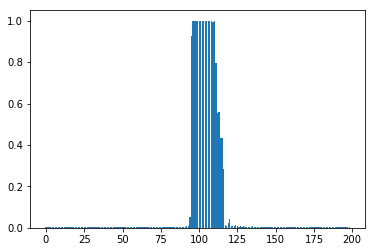

In [182]:
test_pred = dl_model(valid_x)
plt.bar(left = range(199), height = test_pred[10])
plt.show()